In [1]:
import math
import os
import sys
from copy import copy
import matplotlib.pyplot as plt
import time
from mpl_toolkits.basemap import Basemap
import xarray as xr
import numpy as np

sys.path.append("C:/Users/giorg/PythonRobotics/PathPlanning/RRT/")
try:
    from rrt import RRT
except ImportError:
    raise

In [2]:
data = xr.open_dataset('med-hcmr-wav-an-fc-h_1637573239403.nc')  # wave height 22 november
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
time = data.variables['time'][:]
wave = data.variables['VHM0'][:]
mask = data_stat.variables['mask'][0,:,:]
print(data)
print("------------------------------------------------------")
print(data_stat)

<xarray.Dataset>
Dimensions:    (latitude: 380, time: 24, longitude: 1307)
Coordinates:
  * latitude   (latitude) float32 30.19 30.23 30.27 30.31 ... 45.9 45.94 45.98
  * time       (time) datetime64[ns] 2021-11-22 ... 2021-11-22T23:00:00
  * longitude  (longitude) float32 -18.12 -18.08 -18.04 ... 36.21 36.25 36.29
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date:                   2021-11-21 12
    FROM_ORIGINAL_FILE__field_type:  hourly_instanta

In [23]:
class RRTStar(RRT):
    """
    Class for RRT Star planning
    """

    class Node(RRT.Node):
        def __init__(self, x, y):
            super().__init__(x, y)
            self.cost = 0.0  # taking into account the cost

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=20000.0,
                 path_resolution=1.0,
                 goal_sample_rate=10,
                 max_iter=3000,
                 connect_circle_dist=10.0,  # RRT* parameter: planning constant for the recomputing of the cost
                 search_until_max_iter=False):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]

        """
        super().__init__(start, goal, obstacle_list, rand_area, expand_dis, path_resolution, goal_sample_rate, max_iter)
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal[0], goal[1])
        self.search_until_max_iter = search_until_max_iter

    def planning(self, animation=True):
        """
        rrt star path planning

        animation: flag for animation on or off .
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)  # nearest index
            near_node = self.node_list[nearest_ind]  # nearest node of the list to the rnd point just found
            new_node = self.steer(near_node, rnd, self.expand_dis)  # at each iter new node change of expand_dis
            new_node.cost = near_node.cost + math.hypot(new_node.x-near_node.x, new_node.y-near_node.y)  # adding cost

            if self.check_collision(new_node, self.obstacle_list):
                near_inds = self.find_near_nodes(new_node)  # now we have the indexes of nodes near new_node
                node_with_updated_parent = self.choose_parent(new_node, near_inds)  # arguments: new node and indexes
                if node_with_updated_parent:
                    self.rewire(node_with_updated_parent, near_inds)
                    self.node_list.append(node_with_updated_parent)
                else:
                    self.node_list.append(new_node)

            if animation:
                self.draw_graph(rnd)

            if (not self.search_until_max_iter) and new_node:  # if reaches goal
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index), new_node.cost, i

            #self.obstacle_list[-1][0] -= 100  # vertical movement of the last obs
            #self.obstacle_list[-2][1] += 100  # vertical movement of the penultimate obs
            #self.obstacle_list[-1][2] += 20   # radius change of the last obs
        print("reached max iteration")

        last_index = self.search_best_goal_node()   # if I want to search until reached max iteration
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and the tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:  # in a for loop
            near_node = self.node_list[i]  # the near node is each of the list with the corresponding list
            t_node = self.steer(near_node, new_node)  # it finds the node attached to new_node and define parent near_n
            if t_node and self.check_collision(t_node, self.obstacle_list):
                costs.append(self.calc_new_cost(near_node, new_node))  # the function calc the cost as a distance
            else:  # costs is a list
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]  # find the index of near node (in the ball) with min cost
        new_node = self.steer(self.node_list[min_ind], new_node)  # segment between the min cost node and new node
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        dist_to_goal_list = [self.calc_dist_to_goal(n.x, n.y) for n in self.node_list]
        goal_inds = [dist_to_goal_list.index(i) for i in dist_to_goal_list if i <= self.expand_dis]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(t_node, self.obstacle_list):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        min_cost = min([self.node_list[i].cost for i in safe_goal_inds])
        for i in safe_goal_inds:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """
        1) defines a ball centered on new_node
        2) Returns all nodes of the tree that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt((math.log(nnode) / nnode))
        # if expand_dist exists, search vertices in a range no more than expand_dist
        # if hasattr(self, 'expand_dis'):
        # r = min(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]  # compute distance of each node from the new_node
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds  # returns the index list of those points with a distance smaller than the ball radius

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            # calc the cost as distance from node with new parent and nodes in the ball
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(edge_node, self.obstacle_list)
            improved_cost = near_node.cost > edge_node.cost  # can be True or False

            if no_collision and improved_cost:  # if True change near node with edge node
                near_node.x = edge_node.x
                near_node.y = edge_node.y
                near_node.cost = edge_node.cost
                near_node.path_x = edge_node.path_x
                near_node.path_y = edge_node.path_y
                near_node.parent = edge_node.parent
                self.propagate_cost_to_leaves(new_node)

    def calc_new_cost(self, from_node, to_node):
        d, _ = self.calc_distance_and_angle(from_node, to_node)
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):  # a recursive way to compute the cost of the path till the start

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

Start!


Press a number between 1 and 3 
 1


Scenario 1 has been pressed


<ipython-input-43-bcf6db34338c>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp.pcolor(x, y, wave[0], cmap='jet')


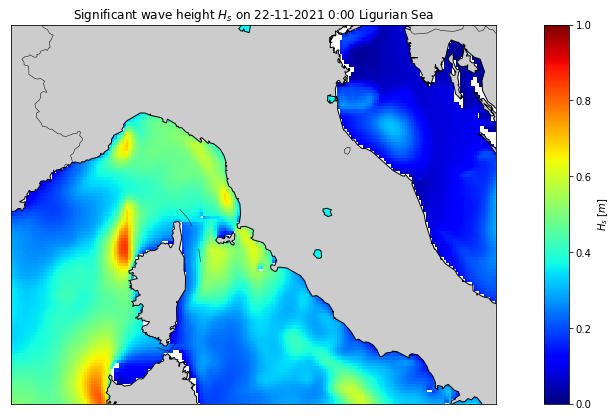

In [43]:
print("Start!")
scenario = input('Press a number between 1 and 3 \n')
print("Scenario " + scenario + " has been pressed")

plt.figure(1, figsize=(10, 7))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i')

lon, lat = np.meshgrid(lons, lats)
x, y = mp(lon, lat)

c_scheme = mp.pcolor(x, y, wave[0], cmap='jet')
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

cbar = mp.colorbar(c_scheme, location='right', pad='10%')
plt.clim(0, 1)
cbar.set_label('$H_s$ $[m]$')

plt.title('Significant wave height $H_s$ on 22-11-2021 0:00 Ligurian Sea')
plt.show()

200663.38208287852 176101.98864075355 553750.5851325865 250766.70724292006


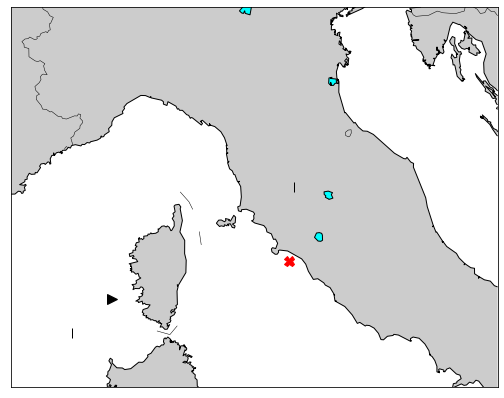

x_min = 121258.01040744488, y_min = 107690.0256157238
x_max = 563485.5851813362, y_max = 398436.67947562877


In [25]:
x_min, y_min = mp(7.51050, 41.31151)
x_max, y_max = mp(11.48755, 43.24587)

sx, sy = mp(8.22461, 41.77200)
gx, gy = mp(11.400001, 42.270832)
print(sx, sy, gx, gy)

plt.figure(2, figsize=(10, 7))
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot(x_min, y_min, "|k", markersize=10)
plt.plot(x_max, y_max, "|k", markersize=10)
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

plt.show()

print("x_min = {}, y_min = {}\nx_max = {}, y_max = {}".format(x_min, y_min, x_max, y_max))

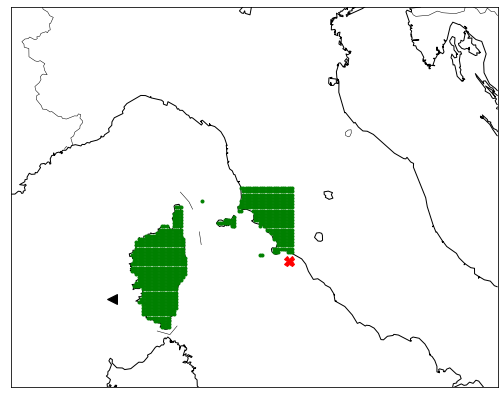

In [26]:
oxland, oyland = [], []
oxmeteo, oymeteo = [], []
for i in np.arange(0, 380, 1):
    for j in np.arange(0, 1307, 1):
        if mask.values[i][j] == 0:
            if 7.51050 <= lons.values[j] <= 11.48755 and 41.31151 <= lats.values[i] <= 43.24587:
                oxland.append(lons.values[j])
                oyland.append(lats.values[i])

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
oxland_, oyland_ = mp(oxland, oyland)
oxmeteo_, oymeteo_ = mp(oxmeteo, oymeteo)
plt.plot(oxland_, oyland_, ".g")
plt.plot(sx, sy, "<k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.show()

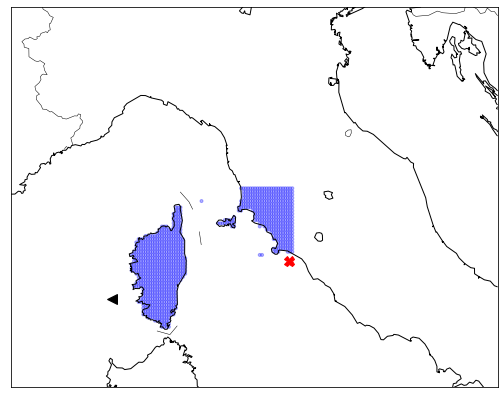

In [44]:
obstacle_list = []
for i, _ in enumerate(oxland):
    obstacle_list.append([oxland_[i], oyland_[i], 3000])


fig, ax = plt.subplots(1, 1, figsize=(10, 7))

mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.plot(sx, sy, "<k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
for i in range(len(obstacle_list)):
    ax.add_patch(plt.Circle(xy=(obstacle_list[i][0], obstacle_list[i][1]), radius=obstacle_list[i][2],
                            color='b', alpha=0.3))
plt.show()

In [45]:
rrt_star = RRTStar(
            start=[sx, sy],
            goal=[gx, gy],
            rand_area=[x_min, x_max, y_min, y_max],
            obstacle_list=obstacle_list,
            expand_dis=20000)

In [46]:
show_animation = False
path, cost_tot, iter_tot = rrt_star.planning(animation=show_animation)

if path is None:
    print("Cannot find path")
else:
    print("Found path!!")

Iter: 0 , number of nodes: 1
Iter: 1 , number of nodes: 2


KeyboardInterrupt: 

NameError: name 'plt' is not defined